# Exercise 3 (Audio Analysis + Steganography)

This notebook implements Exercise 3.1 and 3.2.
3.1: Detect file containing ultrasonic "secret message" and demodulate it into an audible signal so the hidden 4-digit code can be heard clearly.
3.2: Embed and extract a text message using a more sophisticated LSB(Least Significant Bit) steganography method.

### Task 3.1 – Detect ultrasonic content

The coursework states that secret code is amplitude modulated and hidden in ultrasonic frequency range.
To identify the correct file (sound1–sound4), we compute a spectrum and measure the energy ratio:

Ultrasonic band: 18 kHz - 22 kHz (or Nyquist max freq)
Reference audible band: 20 Hz → 20 kHz

The file with the highest ratio is the most suspicious candidate for containing the hidden code.

In [71]:
from pathlib import Path
import soundfile as sf
import numpy as np

# Project folders
PROJECT_ROOT = Path.cwd()
ASSETS_DIR = PROJECT_ROOT / 'assets'
OUTPUTS_DIR = PROJECT_ROOT / 'outputs'
OUTPUTS_DIR.mkdir(exist_ok=True)

# Sound files
SOUND_FILES_3_1 = [ASSETS_DIR / f'Ex3_sound{i}.wav' for i in range(1, 5)]

def load_wav_mono(path: Path):
    '''
    Load a WAV file, cast it to mono of float32 samples.
    Returns: (samples_mono_float32, sample_rate)
    '''
    # Guard clause
    if not Path.exists(path): 
        raise FileExistsError('Path not found!')

    # Read sound file (as 2d arr to ensure uniform data)
    data, samplerate = sf.read(str(path), always_2d=True)

    # Cast all samples to same datatype (uniform sample type)
    samples = data.astype(np.float32)

    # Average channels for each sample in case we have stereo sound
    if samples.shape[1] > 1:
        samples = np.mean(samples, axis=1)
    # Just use mono sound
    else:
        samples = samples[:, 0]

    return samples, samplerate

# Ensure all assets present
print('Assets folder:', ASSETS_DIR)
for file in SOUND_FILES_3_1:
    print(' -', file.name, '| exists:', file.exists())

# Check that function works
samples, samplerate = load_wav_mono(SOUND_FILES_3_1[0])
print(f'\nLoaded {SOUND_FILES_3_1[0].name}: {len(samples)} samples, samplerate={samplerate} Hz, duration={len(samples)/samplerate:.2f}s')

Assets folder: /home/penguin/my_projects/cm3065_isp/exercise3/assets
 - Ex3_sound1.wav | exists: True
 - Ex3_sound2.wav | exists: True
 - Ex3_sound3.wav | exists: True
 - Ex3_sound4.wav | exists: True

Loaded Ex3_sound1.wav: 705600 samples, samplerate=44100 Hz, duration=16.00s


In [72]:
def fft_slice(samples: np.ndarray, samplerate: int, fft_sample_limit: int = 65536, min_sample_size: int = 2048):
    '''
    Calculate a windowed FFT slice of the audio.
    If not enough samples, returns (None, None, 0).

    Returns:
        freqs: 1D array of frequency bin centers (Hz)
        fft_values: rFFT spectrum
        fft_size: FFT size actually used
    '''
    # Limit FFT size
    fft_size = min(len(samples), fft_sample_limit)
    if fft_size < min_sample_size:
        return None, None, 0

    # To clearly analyze sound, we need to remove DC (Direct Current) offset (by substractin the mean)
    cleaned_samples = samples[:fft_size] - np.mean(samples[:fft_size])

    # Smooth out edges of the signal segment, so we not confuse analyzer and get better result
    window = np.hanning(fft_size).astype(np.float32)

    # List of all frequencies
    freqs = np.fft.rfftfreq(fft_size, d=1.0 / samplerate)

    # FFT (Amplitude value for each frequency)
    fft_values = np.fft.rfft(cleaned_samples * window)

    return freqs, fft_values, fft_size

def spectrum_power(fft_values: np.ndarray) -> np.ndarray:
    '''Calculate a power per frequency bin'''
    return (np.abs(fft_values) ** 2)

def spectrum_magnitude_db(spectrum: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    '''Magnitude in dB for plotting'''
    return 20.0 * np.log10(np.abs(spectrum) + eps)

In [73]:
def band_energy_ratio(raw_samples: np.ndarray, samplerate: int, band_low_hz: float, band_high_hz: float, fft_sample_limit: int = 65536):
    '''
    Return energy ratio: energy_in_band / energy_in_reference_band.
    It helps us to see if sound has simmilar "dominating" band.
    We will use it to see if samples has a lot of energy in ultrasonic band
    '''
    # Calculate FFT for the sample
    freqs, fft_values, _ = fft_slice(raw_samples, samplerate, fft_sample_limit=fft_sample_limit)

    # Guard clause
    if fft_values is None:
        return np.nan

    # Calculate power
    power = spectrum_power(fft_values)

    # Helper function to calculate energy in specified freq range
    def range_energy(low, high):
        # Frequency bin mask
        mask = (freqs >= low) & (freqs <= high)
        # Gaurd clause
        if not np.any(mask):
            return 0.0

        return float(np.sum(power[mask]))

    # Calculate highest freq that can be acuratly captured (Nyquist freq) 
    nyq_freq = samplerate / 2

    # Clamp low/high band range argument, so it is valid [0, nyq_freq]
    band_low = max(0.0, min(band_low_hz, nyq_freq))
    band_high = max(0.0, min(band_high_hz, nyq_freq))

    # Audible freq range that works as reference (max is clamped too)
    ref_low, ref_high = 20.0, min(20000.0, nyq_freq)

    # Energy for band and reference range (with epsilon addition to prevent division by 0)
    energy_band = range_energy(band_low, band_high)
    energy_ref = range_energy(ref_low, ref_high) + 1e-12

    return energy_band / energy_ref

def scan_ultrasonic(files):
    rows = []
    for file in files:
        # Load fiel
        samples, samplerate = load_wav_mono(file)
        # Ultrasonic freq range
        ultra_low = 18000.0
        ultra_high = 22000.0

        # Calculate highest freq and 
        nyq_freq = samplerate / 2

        # If highest frequency too small
        if nyq_freq <= ultra_low:
            ratio = np.nan
        # If it is ok - check ratio o the band compared to ultrasonic range
        else:
            ratio = band_energy_ratio(samples, samplerate, ultra_low, ultra_high)

        # Store calculation
        rows.append((
            file.name, 
            samplerate, 
            len(samples)/samplerate, 
            ultra_low, 
            ultra_high, 
            ratio
        ))

    return rows

# Scan files and check ultrasonic range
rows = scan_ultrasonic(SOUND_FILES_3_1)
# Sort rows, based on the ratio (highest on top)
ultrasonic_check_res = sorted(rows, key=lambda row: row[-1], reverse=True)

# Log scan results
print('Ultrasonic scan (higher ratio -> more suspicion):\n')
for (name, samplerate, duration, low, high, ratio) in ultrasonic_check_res:
    print(f'{name:12s} | samplerate={samplerate:6d} | duration={duration:6.2f}s | band={low:7.1f}-{high:7.1f} Hz | ratio={ratio:.6e}')

Ultrasonic scan (higher ratio -> more suspicion):

Ex3_sound4.wav | samplerate= 48000 | duration=  6.24s | band=18000.0-22000.0 Hz | ratio=3.429863e-01
Ex3_sound1.wav | samplerate= 44100 | duration= 16.00s | band=18000.0-22000.0 Hz | ratio=1.699287e-03
Ex3_sound2.wav | samplerate= 48000 | duration= 13.16s | band=18000.0-22000.0 Hz | ratio=2.089477e-09
Ex3_sound3.wav | samplerate= 48000 | duration=  5.91s | band=18000.0-22000.0 Hz | ratio=1.643300e-09


#### Task 3.1 – Spectrum and spectrogram evidence

After selecting the most suspicious file, we plot:
- A full spectrum to show overall frequency content.
- A zoomed ultrasonic spectrum to locate the carrier region.
- A spectrogram (full + zoomed) to confirm a ultrasonic carrier over time.

Ex3_sound4.wav: samplerate=48000, duration=6.24s, highest_freq (Nyquist)=24000.0 Hz


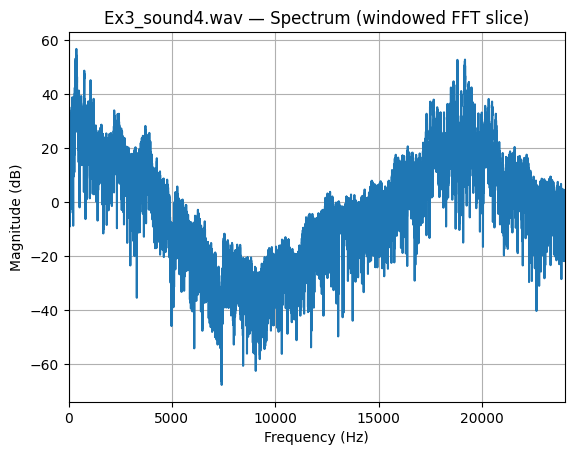

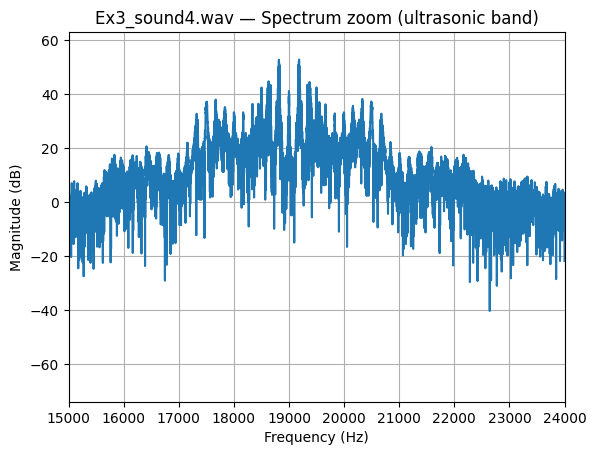

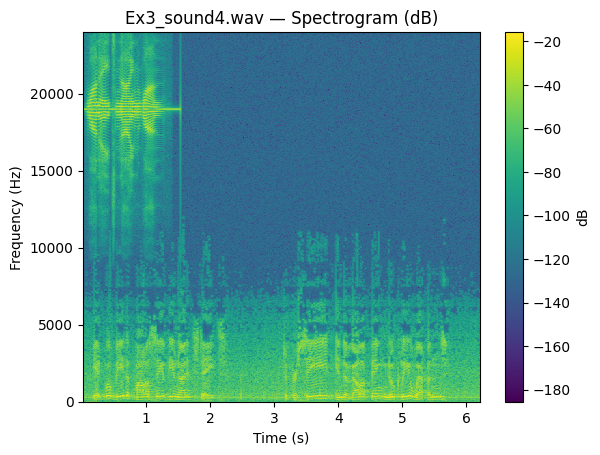

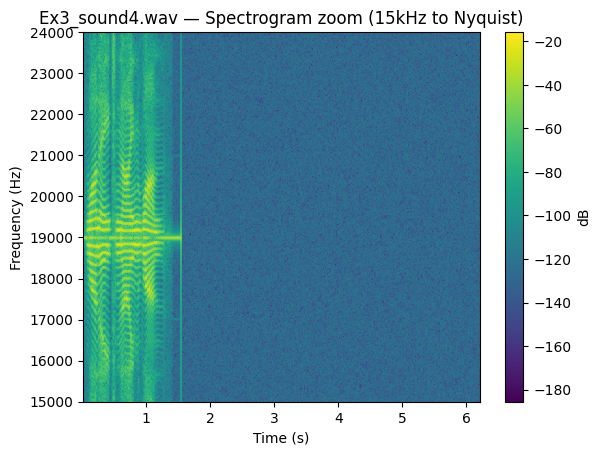

In [74]:
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# Guard clause
suspicious_f_name = ultrasonic_check_res[0][0] if len(ultrasonic_check_res) > 0 else None
if not suspicious_f_name:
    raise ValueError('Ultrasonic scan failed, no suspicious file row!')

# We identified most suspicious audio file on step 2
suspicious_file = ASSETS_DIR / suspicious_f_name
# Load it
samples, samplerate = load_wav_mono(suspicious_file)
# Calculate sound duration
duration = len(samples) / samplerate
# Calculate highest freq that can be acuratly captured (Nyquist freq) 
nyq_freq = samplerate / 2

# Log file stats
print(f'{suspicious_file.name}: samplerate={samplerate}, duration={duration:.2f}s, highest_freq (Nyquist)={nyq_freq:.1f} Hz')

# Limit sample size
SAMPLE_LIMIT = 65536

# Calculate fft
freqs, fft_values, fft_size = fft_slice(samples, samplerate, fft_sample_limit=SAMPLE_LIMIT)

# Guard clause
if freqs is None or fft_values is None:
    raise ValueError('FFT calculation failed! Check fft_slice...')

# Calculate magnitude
magnitude = spectrum_magnitude_db(fft_values)

# Plot spectrum
plt.figure()
plt.plot(freqs, magnitude)
plt.title('Ex3_sound4.wav — Spectrum (windowed FFT slice)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.xlim(0, nyq_freq)
plt.grid(True)
plt.show()

# Plot Zoomed ultrasonic region
plt.figure()
plt.plot(freqs, magnitude)
plt.title('Ex3_sound4.wav — Spectrum zoom (ultrasonic band)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.xlim(15000, nyq_freq)
plt.grid(True)
plt.show()

# Soundfile spectrogram and magnitude
sound_freqs, sound_time, sound_spectr  = spectrogram(x=samples, fs=samplerate, window='hann', nperseg=2048, noverlap=1536, scaling='spectrum', mode='magnitude')
sound_spectr_db = spectrum_magnitude_db(sound_spectr)

# Plot spectrogram
plt.figure()
plt.pcolormesh(sound_time, sound_freqs, sound_spectr_db, shading='auto')
plt.title('Ex3_sound4.wav — Spectrogram (dB)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0, nyq_freq)
plt.colorbar(label='dB')
plt.show()

# Plot spectrogram zoomed on ultrasonic carrier frequency
plt.figure()
plt.pcolormesh(sound_time, sound_freqs, sound_spectr_db, shading='auto')
plt.title('Ex3_sound4.wav — Spectrogram zoom (15kHz to Nyquist)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(15000, nyq_freq)
plt.colorbar(label='dB')
plt.show()

#### Task 3.1 — Demodulation (making the ultrasonic message intelligible)

The spectral/spectrogram scan shows a strong, narrow ultrasonic component around ~19 kHz during the first 2 seconds of Ex3_sound4.wav. These suggest the hidden digits were shifted to ultrasonic band-pass channel and amplitude-modulated around a carrier in that region.

##### Chosen approach - Coherent mix-down demodulation:

1. Band-pass filtering isolates ultrasonic channel around the estimated carrier region. Implementation uses Butterworth infinite impulse response (IIR) filter, using second-order sections for numerical stability as it is a [recommended approach](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html#:~:text=If%20the%20transfer%20function%20form%20%5Bb%2C%20a%5D%20is%20requested%2C%20numerical%20problems%20can%20occur%20since%20the%20conversion%20between%20roots%20and%20the%20polynomial%20coefficients%20is%20a%20numerically%20sensitive%20operation%2C%20even%20for%20N%20%3E%3D%204.%20It%20is%20recommended%20to%20work%20with%20the%20SOS%20representation.).

2. We compute analytic signal using Hilbert transform to [determine amp envelope](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html#:~:text=In%20this%20example%20we%20use%20the%20Hilbert%20transform%20to%20determine%20the%20amplitude%20envelope%20and%20instantaneous%20frequency%20of%20an%20amplitude%2Dmodulated%20signal.), which provides a complex representation of the band-pass signal.

3. We then mix down that signal to shift ultrasonic band to baseband.

4. A low-pass filter removes leftover high-frequency artefacts, leaving the recovered baseband message. A small high-pass filter removes DC offset.

5. In the end, we normalize filtered signal, save it to outputs and integrate it in the notebook.

In [75]:
from scipy.signal import butter, sosfiltfilt, hilbert

# === HELPERS ===

# Helper Butterworth filter functions [https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html]
def design_bandpass_sos(low_hz: float, high_hz: float, samplerate: int, order: int = 6):
    '''
        Butterworth band-pass as second-order sections (SOS).
        The second-order sections (SOS) output in a Butterworth
    '''
    nyq_freq = samplerate / 2.0

    # Calculate two first-order stages (low/high cut off range) for more effective filtering
    low = max(1.0, low_hz) / nyq_freq
    high = min(high_hz, nyq_freq * 0.999) / nyq_freq

    if low >= high:
        raise ValueError('Invalid band-pass cutoffs.')

    return butter(order, [low, high], btype='bandpass', output='sos')

def design_lowpass_sos(cut_hz: float, samplerate: int, order: int = 6):
    '''Butterworth low-pass as SOS.'''
    nyq_freq = samplerate / 2.0
    cut = min(cut_hz, nyq_freq * 0.999) / nyq_freq

    return butter(order, cut, btype='lowpass', output='sos')

def design_highpass_sos(cut_hz: float, samplerate: int, order: int = 4):
    '''Butterworth high-pass as SOS (removes DC drift / very low rumble).'''
    nyq_freq = samplerate / 2.0
    cut = max(1.0, cut_hz) / nyq_freq

    return butter(order, cut, btype='highpass', output='sos')

# Helper function to demodulate ultrasonic signal
def coherent_mixdown_demodulator(
    ultrasonic_band: np.ndarray,
    samplerate: int,
    carrier_hz: float,
    baseband_lp_hz: float = 6000.0,
    dc_hp_hz: float = 50.0
):
    '''
    Coherent demodulation steps:
    1 Convert band-pass real signal -> complex analytic signal via Hilbert transform.
    2 Mix down (as we use complex number we multiply by exp(-j*2pi*f_c*t) instead of cosine wave [cos(2pi*f_c*t)]) to shift carrier to ~0 Hz (baseband).
    3 Take real part (baseband audio-like component).
    4 Low-pass to keep only message signal.
    5 High-pass to remove DC drift.
    6 Normalize for playback.
    '''
    # Time (discrete form)
    t = np.arange(len(ultrasonic_band)) / samplerate

    # 1.Analytic signal (complex representation of band-pass waveform)
    analytic = np.asarray(hilbert(ultrasonic_band), dtype=np.complex64)

    # 2.Complex mixing to baseband (https://dsp.stackexchange.com/questions/29076/extracting-multiple-signals-to-baseband)
    mixer = np.exp(-1j * 2.0 * np.pi * carrier_hz * t).astype(np.complex64)
    baseband_complex = analytic * mixer

    # 3.Real part gives the recovered baseband component
    baseband = np.real(baseband_complex).astype(np.float32)

    # 4.Pass signal through the low-pass filter (keep only message)
    sos_lp = design_lowpass_sos(baseband_lp_hz, samplerate, order=6)
    baseband = sosfiltfilt(sos_lp, baseband)

    # 5.Same for the high-pass filter (remove DC current), but only slight filter (smaller order for less steep roll off)
    sos_hp = design_highpass_sos(dc_hp_hz, samplerate, order=4)
    baseband = sosfiltfilt(sos_hp, baseband)

    # 6.Normalize for listening
    baseband = baseband - np.mean(baseband)
    baseband = baseband / (np.max(np.abs(baseband)) + 1e-12)

    return baseband


# === MAIN PIECES ===

def estimate_ultrasonic_peak_band(
    signal: np.ndarray,
    samplerate: int,
    low_search: float = 17000.0,
    high_search: float | None = None,
    fft_sample_limit: int = 65536,
    half_band_hz: float = 4000.0
):
    '''
    Finds the strongest FFT peak within [low_search, high_search] and return (peak_freq_hz, band_low_hz, band_highgh_hz)
    '''
    # Use nyq frequency as high search as default
    if high_search is None:
        high_search = samplerate / 2.0

    # Calculate FFT
    freqs, fft_values, _ = fft_slice(
        signal,
        samplerate,
        fft_sample_limit=fft_sample_limit,
        min_sample_size=4096
    )

    # Guard clause
    if freqs is None or fft_values is None:
        raise ValueError('Signal too short for reliable peak estimation.')

    # Calculate magnituded
    magnitude = np.abs(fft_values)

    # Frequency mask
    mask = (freqs >= low_search) & (freqs <= high_search)
    if not np.any(mask):
        raise ValueError('Search band invalid for this sample rate.')

    # Find peak frequency
    peak_ind = np.argmax(magnitude[mask])
    peak_freq = float(freqs[mask][peak_ind])

    # Rentur band range around peak frequency
    band_low = max(low_search, peak_freq - half_band_hz)
    band_high = min(high_search, peak_freq + half_band_hz)

    return peak_freq, band_low, band_high

def choose_best_carrier_frequency(
    ultrasonic_band: np.ndarray,
    samplerate: int,
    freq_initial: float,
    search_range_hz: float = 250.0,
    step_hz: float = 5.0,
    baseband_lp_hz: float = 8000.0
):
    '''
    We will try a small range around initial frequency and pick the carrier that maximizes 'speech-likeness' score:
    score = energy_mid / (energy_low + energy_high)
    [https://www.bksv.com/media/doc/bo0521.pdf]
    '''
    # Simple helper to calculate fft energy for a band range
    def fft_band_energy(samples: np.ndarray, low: float, high: float):
        fft_size = min(len(samples), 65536)
        window = np.hanning(fft_size)
        fft_values = np.fft.rfft(samples[:fft_size] * window)
        freqs = np.fft.rfftfreq(fft_size, 1 / samplerate)
        mask = (freqs >= low) & (freqs <= high)
        power = (np.abs(fft_values[mask]) ** 2)

        return float(np.sum(power) + 1e-12)

    # Initial values
    best_freq = freq_initial
    best_score = -np.inf
    best_baseband = None

    # Iterate over small ranges and calculate energy score
    for df in np.arange(-search_range_hz, search_range_hz + step_hz, step_hz):
        tested_freq = freq_initial + df

        candidate = coherent_mixdown_demodulator(
            ultrasonic_band, samplerate, carrier_hz=tested_freq, baseband_lp_hz=baseband_lp_hz
        )

        # Energy levels based on Relative octave bands for humans [https://www.bksv.com/media/doc/bo0521.pdf] 
        energy_low = fft_band_energy(candidate, 0, 125)
        energy_mid = fft_band_energy(candidate, 250, 4000)
        energy_high = fft_band_energy(candidate, 8000, min(samplerate / 2, 12000))

        # Calculate score
        score = energy_mid / (energy_low + energy_high)

        # Update best carrier frequency
        if score > best_score:
            best_score = score
            best_freq = tested_freq
            best_baseband = candidate

    return best_freq, best_score, best_baseband

In [76]:
# 1.Estimate ultrasonic peak and choose a band around it (main piece 1)
peak_hz, band_loww_hz, band_highgh_hz = estimate_ultrasonic_peak_band(
    samples, samplerate,
    low_search=17000.0,
    high_search=samplerate / 2.0,
    half_band_hz=4000.0
)

print(f'Estimate ultrasonic peak ~ {peak_hz:.1f} Hz; band-pass {band_loww_hz:.1f}–{band_highgh_hz:.1f} Hz')

# 2.Create and apply nand-pass filter to isolate ultrasonic channel
sos_bp = design_bandpass_sos(band_loww_hz, band_highgh_hz, samplerate, order=6)
ultra_channel = sosfiltfilt(sos_bp, samples)

# 3.Identify best carrier frequency (main piece 2)
best_freq_hz, best_score, recovered_baseband = choose_best_carrier_frequency(
    ultra_channel, samplerate,
    freq_initial=peak_hz,
    search_range_hz=300.0,
    step_hz=5.0,
    baseband_lp_hz=6000.0
)

# Guard clause
assert recovered_baseband is not None, 'Carrier search failed to produce baseband signal'

print(f'Chosen carrier ={best_freq_hz:.2f} Hz (score={best_score:.3g})')

# 4.Save recovered audio
out_path = OUTPUTS_DIR / 'ex3_secret_code.wav'

sf.write(str(out_path), recovered_baseband, samplerate)

print('Saved secret code audio to:', out_path)

# 6.Integrate player in a notebook
Audio(recovered_baseband, rate=samplerate)

Estimate ultrasonic peak ~ 19183.6 Hz; band-pass 17000.0–23183.6 Hz
Chosen carrier =18998.59 Hz (score=1.26e+03)
Saved secret code audio to: /home/penguin/my_projects/cm3065_isp/exercise3/outputs/ex3_secret_code.wav
